In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
data = yf.download('AAPL','2008-01-01','2023-03-15')

[*********************100%***********************]  1 of 1 completed


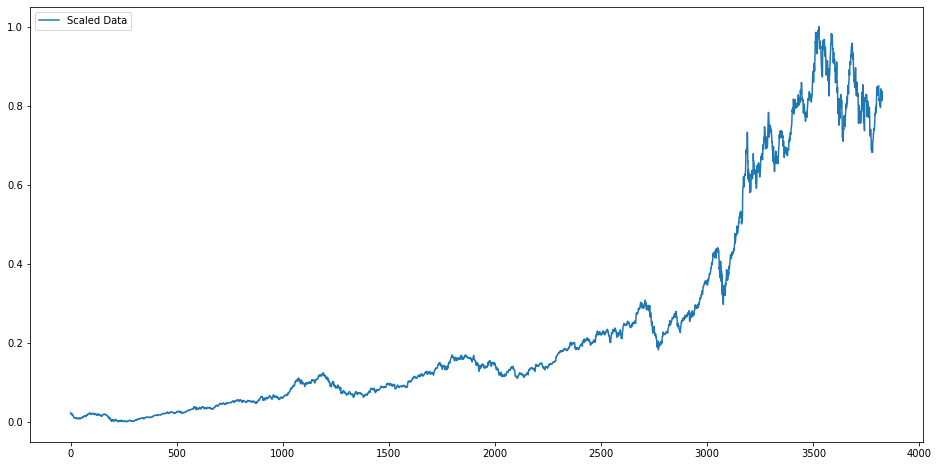

In [3]:
#Scale the data and plot the scaled data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#plot the scaled data from day 0 to current day
plt.figure(figsize=(16,8))
plt.plot(scaled_data, label='Scaled Data')
plt.legend(loc='upper left')
plt.show()

In [4]:
scaled_data.shape

(3826, 1)

In [5]:
print(scaled_data)

[[0.02324395]
 [0.02326189]
 [0.02029661]
 ...
 [0.81302014]
 [0.8240124 ]
 [0.8358416 ]]


In [6]:
#Create a new dataframe with only the 'Close' column
data = data.filter(['Close'])

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on (80% of the data)
training_size = int(np.ceil( len(scaled_data) * .8 ))
test_size = int(np.ceil( len(scaled_data) * .2 ))

#2860 is 80 percent of the total number of rows in the dataset
print("Total Rows in Training Dataset: ", training_size)
print("Total Rows in Testing Dataset: ", test_size)

Total Rows in Training Dataset:  3061
Total Rows in Testing Dataset:  766


In [7]:
#Split the data in to training and testing data, 80% training and 20% testing starting from the beginning of the dataset
train_data = scaled_data[0:training_size , :]
test_data = scaled_data[training_size:len(scaled_data), :]

#remove null values
train_data = train_data[~np.isnan(train_data).any(axis=1)]
test_data = test_data[~np.isnan(test_data).any(axis=1)]

#print the shape of the training and testing data
print("Training Data Shape: ", train_data.shape)
print("Testing Data Shape: ", test_data.shape)

Training Data Shape:  (3061, 1)
Testing Data Shape:  (765, 1)


In [8]:
#Time step is the number of days we want to look back to predict the next closing price
#We need use the training data to create the x_train and y_train data sets where x_train is the closing price of the previous 14 years and y_train is the closing price of the next day
#if data is 120, 130, 125, 140, 134, and 150 then x_train would be 120, 130, 125, 140, 134 and y_train would be 150
#We will do the same for the test data and then check the accuracy of the model

#Function to create the x_train and y_train data sets
def create_dataset (dataset, time_step=1):
    dataX, dataY = [], []
    #Loop through the data and create the x_train and y_train data sets
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] #Start from 0 to time_step and add to a
        dataX.append(a) #Store the values from 0 to time_step in dataX
        dataY.append(dataset[i+time_step, 0]) #Store the value of the next day in dataY
    return np.array(dataX), np.array(dataY) #Return the training data and the testing data as numpy arrays

In [9]:
#time step is the number of days we want to look back to predict the next closing price and we will use 10 days for this model
time_step = 30

#Create the training data set
x_train, y_train = create_dataset(train_data, time_step)

#180 features and 2550 rows
print (x_train.shape) #the training data should have 10 features for 10 days
print (y_train.shape)

(3030, 30)
(3030,)


In [10]:
time_step = 30

#Create the testing data set
x_test, y_test = create_dataset(test_data, time_step)

#180 features an 730 rows
print(x_test.shape)
print(y_test.shape)

(734, 30)
(734,)


In [11]:
print(x_test)

[[0.40124311 0.388005   0.40672528 ... 0.35557227 0.35825056 0.36558805]
 [0.388005   0.40672528 0.39302685 ... 0.35825056 0.36558805 0.38483842]
 [0.40672528 0.39302685 0.38760045 ... 0.36558805 0.38483842 0.38118364]
 ...
 [0.77597012 0.78768778 0.79867996 ... 0.84276061 0.83031763 0.83740395]
 [0.78768778 0.79867996 0.78233112 ... 0.83031763 0.83740395 0.82468196]
 [0.79867996 0.78233112 0.78952905 ... 0.83740395 0.82468196 0.81302014]]


In [12]:
#Reshape the data to fit the LSTM model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [13]:
# Define the number of models to use in the ensemble
num_models = 5

# Define the input shape of your LSTM model
input_shape = (x_train.shape[1], 1)

# Create a list to store the models
models = []

# Train and save each model
for i in range(num_models):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, verbose=0)
    models.append(model)

# Evaluate the models on the test set
y_preds = []
for model in models:
    y_pred = model.predict(x_test)
    y_preds.append(y_pred)

# Average the predictions
y_pred_ensemble = np.mean(y_preds, axis=0)


23/23 [==============================] - 1s 7ms/step


In [14]:
# Calculate the MSE of the ensemble
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)

print("Ensemble MSE:", mse_ensemble)

Ensemble MSE: 0.0004313883264287256


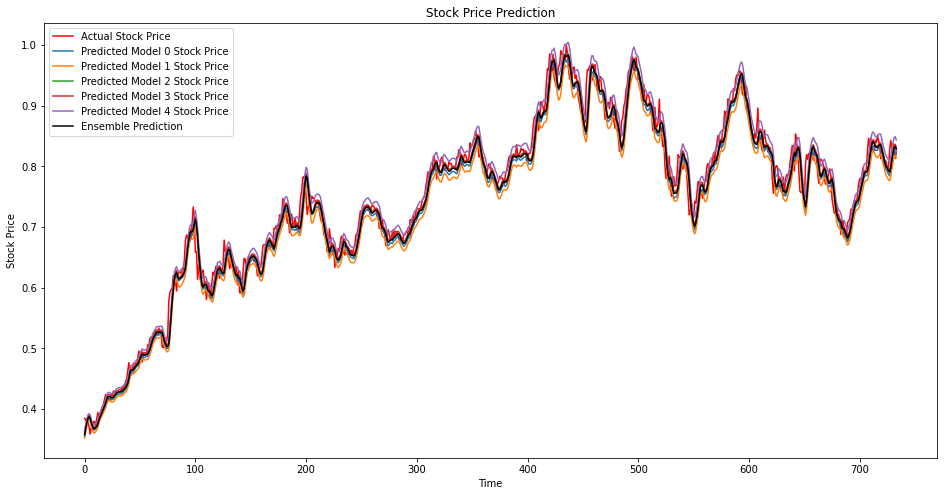

In [15]:
#plot all the models on the same graph
plt.figure(figsize=(16,8))
plt.plot(y_test, color='red', label='Actual Stock Price')
for i in range(num_models):
    plt.plot(y_preds[i], label='Predicted Model '+ str(i) + ' Stock Price')
plt.plot(y_pred_ensemble, color='black', label='Ensemble Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


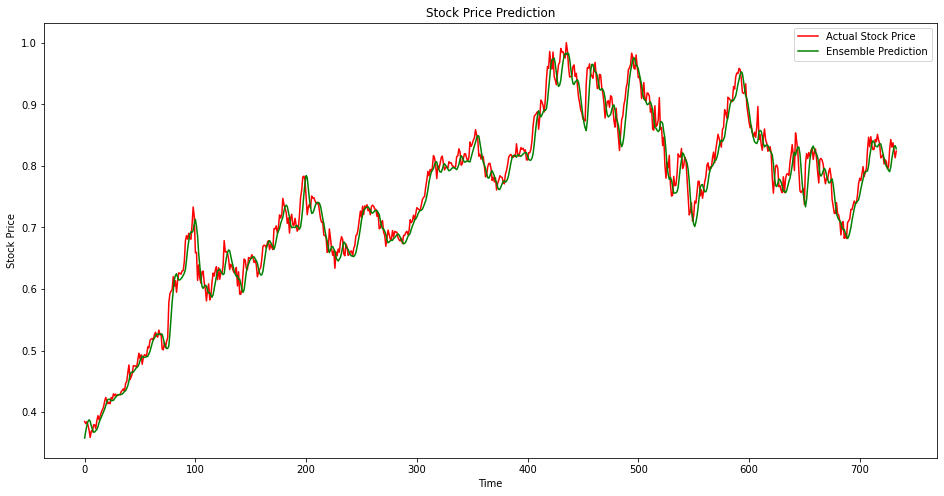

In [16]:
#PLOT the ensemble model and the actual stock price
plt.figure(figsize=(16,8))
plt.plot(y_test, color='red', label='Actual Stock Price')
plt.plot(y_pred_ensemble, color='green', label='Ensemble Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [17]:
#Calculate the root mean squared error (RMSE) to see how accurate the model is
rmse = np.sqrt(np.mean(((y_pred_ensemble - y_test)**2)))
print("Root Mean Squared Error for the Test Data: ", rmse)

Root Mean Squared Error for the Test Data:  0.1948600561173598


In [18]:
#Predict the next 30 days of stock price using the ensemble model
for i in range(30):
    x_test = np.append(x_test, y_pred_ensemble[-1])
    x_test = x_test[1:]
    x_test = x_test.reshape(1, x_test.shape[0], 1)
    y_pred_ensemble = np.append(y_pred_ensemble, model.predict(x_test))


1/1 [==============================] - 1s 957ms/step


In [19]:
print(y_pred_ensemble.shape)


(764,)


In [20]:
#print the predicted stock price for the next 30 days and convert the values back to the original scale
predictions_30 = scaler.inverse_transform(y_pred_ensemble.reshape(-1, 1))

print("Predicted Stock Price for the Next 30 Days: ", predictions_30[734:])

Predicted Stock Price for the Next 30 Days:  [[153.5419 ]
 [153.88412]
 [154.53986]
 [155.41628]
 [156.44914]
 [157.59282]
 [158.81541]
 [160.09453]
 [161.41463]
 [162.7648 ]
 [164.13759]
 [165.52754]
 [166.931  ]
 [168.34517]
 [169.7681 ]
 [171.19826]
 [172.63438]
 [174.07562]
 [175.52107]
 [176.97003]
 [178.42189]
 [179.87605]
 [181.33197]
 [182.7891 ]
 [184.24696]
 [185.70508]
 [187.16301]
 [188.62022]
 [190.07639]
 [191.53088]]


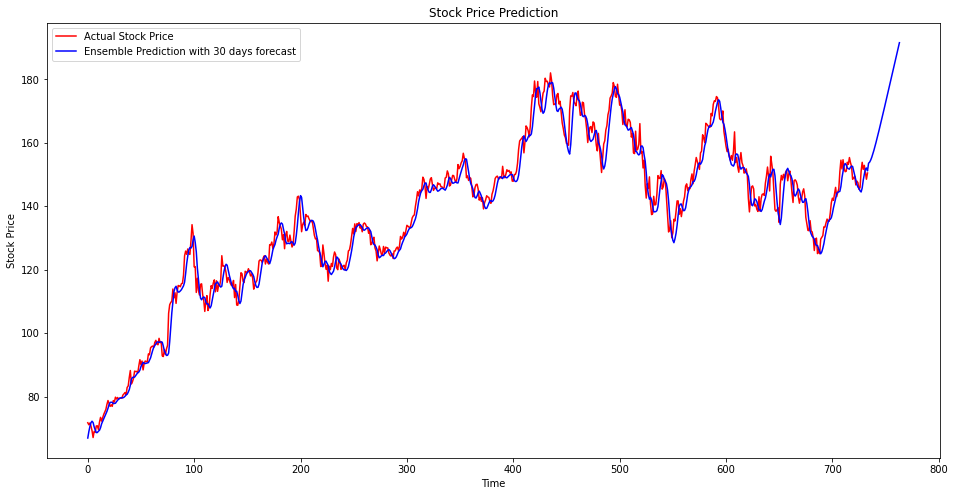

In [30]:
#Plot the predicted stock price for the next 30 days and the actual stock price
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), color='red', label='Actual Stock Price')
plt.plot(predictions_30, color='blue', label='Ensemble Prediction with 30 days forecast')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [22]:
#print(predictions_30)

In [23]:
new_data = yf.download('AAPL','2023-03-16')

[*********************100%***********************]  1 of 1 completed


In [24]:
#Create an array from date 2023-03-15 to 30 days in future 
future_dates = pd.date_range(start='2023-03-16', end='2023-04-14')
#print(future_dates)

#convert it to an array
future_dates = future_dates.to_numpy()
print(future_dates)

future_dates.shape

['2023-03-16T00:00:00.000000000' '2023-03-17T00:00:00.000000000'
 '2023-03-18T00:00:00.000000000' '2023-03-19T00:00:00.000000000'
 '2023-03-20T00:00:00.000000000' '2023-03-21T00:00:00.000000000'
 '2023-03-22T00:00:00.000000000' '2023-03-23T00:00:00.000000000'
 '2023-03-24T00:00:00.000000000' '2023-03-25T00:00:00.000000000'
 '2023-03-26T00:00:00.000000000' '2023-03-27T00:00:00.000000000'
 '2023-03-28T00:00:00.000000000' '2023-03-29T00:00:00.000000000'
 '2023-03-30T00:00:00.000000000' '2023-03-31T00:00:00.000000000'
 '2023-04-01T00:00:00.000000000' '2023-04-02T00:00:00.000000000'
 '2023-04-03T00:00:00.000000000' '2023-04-04T00:00:00.000000000'
 '2023-04-05T00:00:00.000000000' '2023-04-06T00:00:00.000000000'
 '2023-04-07T00:00:00.000000000' '2023-04-08T00:00:00.000000000'
 '2023-04-09T00:00:00.000000000' '2023-04-10T00:00:00.000000000'
 '2023-04-11T00:00:00.000000000' '2023-04-12T00:00:00.000000000'
 '2023-04-13T00:00:00.000000000' '2023-04-14T00:00:00.000000000']


(30,)

In [25]:
#Create empty array of size 30
actual_thirtydays_values = np.empty((30,1))

#Fill the empty array with NaN values
actual_thirtydays_values[:] = np.nan

for i in range(0,30):
  try:
    actual_thirtydays_values[i] = new_data['Close'][i]
  except:
    actual_thirtydays_values[i] = np.nan
    

#Add the date and the actual values to the dataframe
actual_thirtydays_values = pd.DataFrame(actual_thirtydays_values, columns=['Close'])
actual_thirtydays_values['Date'] = future_dates
actual_thirtydays_values = actual_thirtydays_values.set_index('Date')

print (actual_thirtydays_values)

                 Close
Date                  
2023-03-16  155.850006
2023-03-17  155.000000
2023-03-18  157.399994
2023-03-19         NaN
2023-03-20         NaN
2023-03-21         NaN
2023-03-22         NaN
2023-03-23         NaN
2023-03-24         NaN
2023-03-25         NaN
2023-03-26         NaN
2023-03-27         NaN
2023-03-28         NaN
2023-03-29         NaN
2023-03-30         NaN
2023-03-31         NaN
2023-04-01         NaN
2023-04-02         NaN
2023-04-03         NaN
2023-04-04         NaN
2023-04-05         NaN
2023-04-06         NaN
2023-04-07         NaN
2023-04-08         NaN
2023-04-09         NaN
2023-04-10         NaN
2023-04-11         NaN
2023-04-12         NaN
2023-04-13         NaN
2023-04-14         NaN


In [33]:
#add the predicted closing price to the actual closing price
actual_thirtydays_values['Predictions'] = predictions_30[734:]

print(actual_thirtydays_values)

                 Close  Predictions  Accuracy
Date                                         
2023-03-16  155.850006   153.541901  1.480979
2023-03-17  155.000000   153.884125  0.719920
2023-03-18  157.399994   154.539856  1.817114
2023-03-19         NaN   155.416275       NaN
2023-03-20         NaN   156.449142       NaN
2023-03-21         NaN   157.592819       NaN
2023-03-22         NaN   158.815414       NaN
2023-03-23         NaN   160.094528       NaN
2023-03-24         NaN   161.414627       NaN
2023-03-25         NaN   162.764801       NaN
2023-03-26         NaN   164.137589       NaN
2023-03-27         NaN   165.527542       NaN
2023-03-28         NaN   166.931000       NaN
2023-03-29         NaN   168.345169       NaN
2023-03-30         NaN   169.768097       NaN
2023-03-31         NaN   171.198257       NaN
2023-04-01         NaN   172.634384       NaN
2023-04-02         NaN   174.075623       NaN
2023-04-03         NaN   175.521072       NaN
2023-04-04         NaN   176.97003

In [27]:
#Calculate the accuracy from the actual closing price and the predicted closing price for the next 30 days

#calculate accuray by subtracting the actual closing price and the predicted closing price and divide by the actual closing price and multiply by 100 to get the percentage
accuracy = (actual_thirtydays_values['Close'] - actual_thirtydays_values['Predictions']) / actual_thirtydays_values['Close'] * 100

#add the absolute accuracy to the actual closing price and the predicted closing price 
actual_thirtydays_values['Accuracy'] = abs(accuracy)

print (actual_thirtydays_values)


                 Close  Predictions  Accuracy
Date                                         
2023-03-16  155.850006   153.541901  1.480979
2023-03-17  155.000000   153.884125  0.719920
2023-03-18  157.399994   154.539856  1.817114
2023-03-19         NaN   155.416275       NaN
2023-03-20         NaN   156.449142       NaN
2023-03-21         NaN   157.592819       NaN
2023-03-22         NaN   158.815414       NaN
2023-03-23         NaN   160.094528       NaN
2023-03-24         NaN   161.414627       NaN
2023-03-25         NaN   162.764801       NaN
2023-03-26         NaN   164.137589       NaN
2023-03-27         NaN   165.527542       NaN
2023-03-28         NaN   166.931000       NaN
2023-03-29         NaN   168.345169       NaN
2023-03-30         NaN   169.768097       NaN
2023-03-31         NaN   171.198257       NaN
2023-04-01         NaN   172.634384       NaN
2023-04-02         NaN   174.075623       NaN
2023-04-03         NaN   175.521072       NaN
2023-04-04         NaN   176.97003